## Imports en Setup
Hier laden we de libraries.


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
# Zorgt ervoor dat grafieken mooi in de notebook komen

%matplotlib inline

print("Libraries geladen.")

Libraries geladen.


## Paden en Instellingen
We definiëren waar de ruwe data staat en waar de schone data naartoe moet.

In [4]:
# Paden definiëren
# We gaan ervan uit dat deze notebook in de map 'notebooks' staat
BASE_DIR = Path("..") 
RAW_DIR = BASE_DIR / "datasets" / "raw"
CLEAN_DIR = BASE_DIR / "datasets" / "cleaned"

# De schilders (dit moeten de namen van de mappen in 'raw' zijn)
PAINTERS = ["Rembrandt", "Picasso", "Mondriaan", "Rubens"]

print(f"Ruwe data map: {RAW_DIR.resolve()}")
print(f"Schone data map: {CLEAN_DIR.resolve()}")

Ruwe data map: C:\Projects\DeepLearning_Schilderijnen\datasets\raw
Schone data map: C:\Projects\DeepLearning_Schilderijnen\datasets\cleaned


## De Cleaning Functie
Dit is het belangrijkste script (gebaseerd op Slide 8). Het verwijdert corrupte files, zet alles om naar RGB (geen PNG transparantie meer) en hernoemt de bestanden netjes.

In [ ]:
def clean_and_rename_images():
    # Maak de output map schoon (zodat we geen dubbels krijgen als we dit 2x draaien)
    if CLEAN_DIR.exists():
        shutil.rmtree(CLEAN_DIR)
    CLEAN_DIR.mkdir(parents=True, exist_ok=True)

    stats = {}

    for painter in PAINTERS:
        painter_raw_path = RAW_DIR / painter
        painter_clean_path = CLEAN_DIR / painter
        
        # Maak submap aan
        painter_clean_path.mkdir(exist_ok=True)
        
        if not painter_raw_path.exists():
            print(f"⚠️  Map niet gevonden: {painter_raw_path}")
            continue

        files = list(painter_raw_path.iterdir())
        valid_images = 0
        
        print(f"Bezig met {painter} ({len(files)} files)...")
        
        for file_path in tqdm(files, desc=painter):
            try:
                # 1. Probeer te openen en te laden (checkt op corruptie)
                with Image.open(file_path) as img:
                    img.load()
                    
                    # 2. Convert naar RGB (belangrijk voor CNN input!)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    # 3. Opslaan met nieuwe naam
                    # Formaat: rubens_0001.jpg
                    new_filename = f"{painter.lower()}_{valid_images+1:04d}.jpg"
                    save_path = painter_clean_path / new_filename
                    
                    # Sla op als JPEG
                    img.save(save_path, "JPEG", quality=95)
                    valid_images += 1
                    
            except Exception as e:
                # Corrupte file of geen afbeelding
                continue
        
        stats[painter] = valid_images
        print(f"  {valid_images} afbeeldingen opgeslagen voor {painter}.\n")
    
    return stats


# Voer de functie uit
print("Start cleaning process...\n")
final_counts = clean_and_rename_images()
print("\nCleaning voltooid!")


Start cleaning process...

Bezig met Rembrandt (167 files)...


Rembrandt:   0%|          | 0/167 [00:00<?, ?it/s]

  ✅ 167 afbeeldingen opgeslagen voor Rembrandt.

Bezig met Picasso (1529 files)...


Picasso:   0%|          | 0/1529 [00:00<?, ?it/s]

  ✅ 1529 afbeeldingen opgeslagen voor Picasso.

Bezig met Mondriaan (330 files)...


Mondriaan:   0%|          | 0/330 [00:00<?, ?it/s]

  ✅ 330 afbeeldingen opgeslagen voor Mondriaan.

Bezig met Rubens (682 files)...


Rubens:   0%|          | 0/682 [00:00<?, ?it/s]

  ✅ 682 afbeeldingen opgeslagen voor Rubens.


Cleaning voltooid!



## Visualisatie Verdeling (Data Balance)
Hier maken we de grafiek zoals gevraagd in de slides. Dit laat zien of we "Imbalanced Data" hebben.

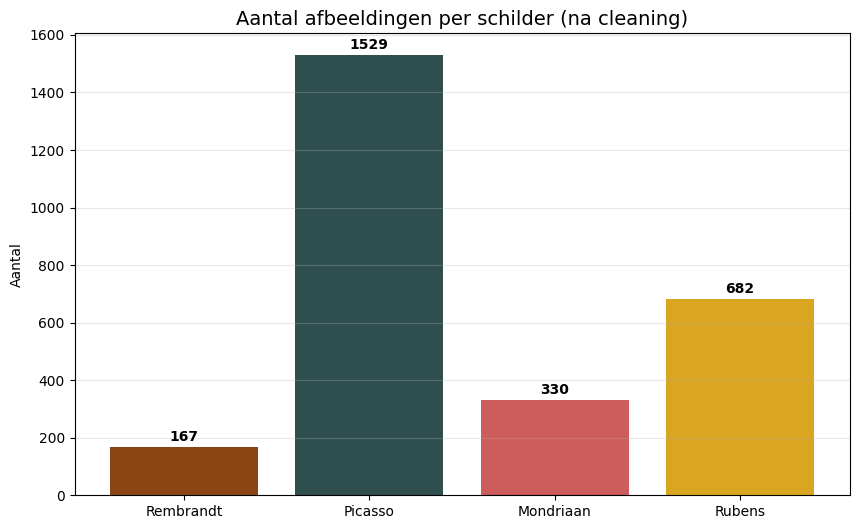

Kleinste klasse: 167
Grootste klasse: 1529
Ratio: 1 : 9.2
⚠️  Let op: De dataset is sterk 'imbalanced'. We zullen data augmentation of class weights nodig hebben.


In [ ]:
# Data voor de grafiek
names = list(final_counts.keys())
values = list(final_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(names, values, color=['#8B4513', '#2F4F4F', '#CD5C5C', '#DAA520'])

plt.title('Aantal afbeeldingen per schilder (na cleaning)', fontsize=14)
plt.ylabel('Aantal')
plt.grid(axis='y', alpha=0.3)

# Zet de getallen boven de balkjes
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{height}', ha='center', va='bottom', fontweight='bold')

plt.show()

# Check voor imbalance
min_count = min(values)
max_count = max(values)
print(f"Kleinste klasse: {min_count}")
print(f"Grootste klasse: {max_count}")
print(f"Ratio: 1 : {max_count/min_count:.1f}")
if max_count / min_count > 2:
    print("Let op: De dataset is sterk 'imbalanced'. We zullen data augmentation of class weights nodig hebben.")

## Analyse Image Sizes (Slide 9)
Volgens Slide 9 moet je statistieken genereren over de afmetingen (breedte en hoogte) om te bepalen hoe groot je input voor het neurale netwerk moet zijn.

--- Statistieken Afmetingen (Slide 9) ---
Aantal images: 2708
Breedte: Min=17, Max=7264, Gemiddelde=608, Mediaan=559
Hoogte:  Min=15, Max=6017, Gemiddelde=652, Mediaan=581


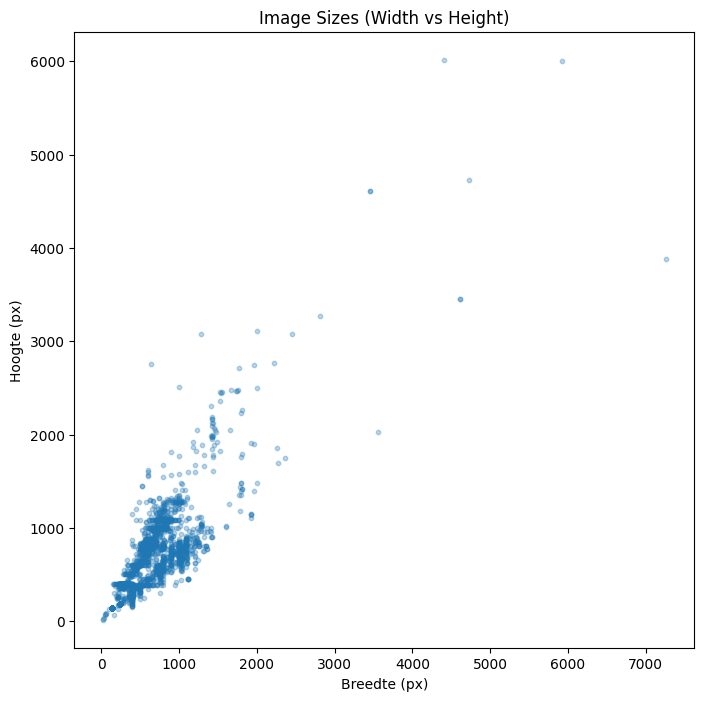

In [7]:
widths = []
heights = []

# Loop door alle clean images om afmetingen te verzamelen
for painter in PAINTERS:
    path = CLEAN_DIR / painter
    for file_path in path.iterdir():
        with Image.open(file_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

# Bereken statistieken
widths = np.array(widths)
heights = np.array(heights)

print(f"--- Statistieken Afmetingen (Slide 9) ---")
print(f"Aantal images: {len(widths)}")
print(f"Breedte: Min={widths.min()}, Max={widths.max()}, Gemiddelde={widths.mean():.0f}, Mediaan={np.median(widths):.0f}")
print(f"Hoogte:  Min={heights.min()}, Max={heights.max()}, Gemiddelde={heights.mean():.0f}, Mediaan={np.median(heights):.0f}")

# Scatterplot van afmetingen
plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, alpha=0.3, s=10)
plt.title("Image Sizes (Width vs Height)")
plt.xlabel("Breedte (px)")
plt.ylabel("Hoogte (px)")
plt.show()

## Voorbeelden tonen
Laat een paar willekeurige foto's zien om te controleren of alles goed is gegaan.

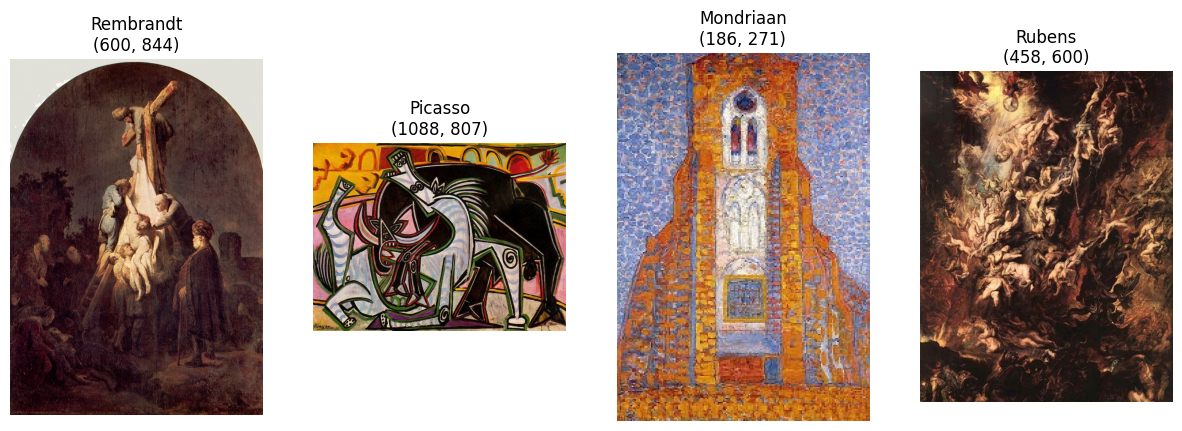

In [8]:
import random

def show_random_images(n=4):
    plt.figure(figsize=(15, 5))
    
    for i, painter in enumerate(PAINTERS):
        path = CLEAN_DIR / painter
        files = list(path.iterdir())
        
        if files:
            # Kies een willekeurige foto
            random_file = random.choice(files)
            img = Image.open(random_file)
            
            plt.subplot(1, 4, i+1)
            plt.imshow(img)
            plt.title(f"{painter}\n{img.size}")
            plt.axis('off')
            
    plt.show()

show_random_images()